# Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

seed = 42

# Loading Data

In [2]:
# loading data
data = pd.read_csv("dataset_test_ds.csv", sep =';')

# variable Safra to Datetime
data['Safra'] = pd.to_datetime(data.Safra,format='%Y%m')  

In [3]:
# Spliting the data in train and Out of time test  df

OOT_test = data.query("Safra > '2019-09-30'")
df = data.query("Safra<= '2019-09-30'")

In [4]:
# Checking the shape of df
df.shape,OOT_test.shape

((8341, 12), (2828, 12))

# EDA


In [5]:
df.head()

,V1,V2,V3,TARGET,V4,V5,V6,V7,V8,V9,V10,Safra
0,0,8.1,9.99,0,1968,0,0,15.15,0,0,0,2019-01-01
2,0,0.7,52.99,0,1228,0,0,98.84,0,0,0,2019-06-01
4,0,4.1,17.50,0,0,0,1,27.70,1,0,0,2019-02-01
6,0,100.0,105.00,0,0,0,1,1331.67,0,0,0,2019-05-01
7,0,0.7,29.00,0,1800,0,0,47.95,1,0,0,2019-01-01


In [6]:
# sumary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,8341.0,0.107421,0.309667,0.0,0.00,0.00,0.00,1.00
V2,8341.0,19.656924,25.447133,0.0,2.70,10.00,25.00,100.00
V3,8341.0,521.238554,892.655655,0.0,36.85,130.00,520.00,8540.00
TARGET,8341.0,0.010670,0.102750,0.0,0.00,0.00,0.00,1.00
V4,8341.0,1372.609519,1679.086631,0.0,23.00,1312.00,1983.00,15616.00
V5,8341.0,0.185349,0.648134,0.0,0.00,0.00,0.00,11.00
V6,8341.0,0.178276,0.382768,0.0,0.00,0.00,0.00,1.00
V7,8341.0,4260.910426,11355.215898,0.0,76.56,404.56,2614.97,137484.87
V8,8341.0,0.401630,0.490257,0.0,0.00,0.00,1.00,1.00
V9,8341.0,0.009471,0.096864,0.0,0.00,0.00,0.00,1.00


Text(0, 0.5, 'Target ratio')

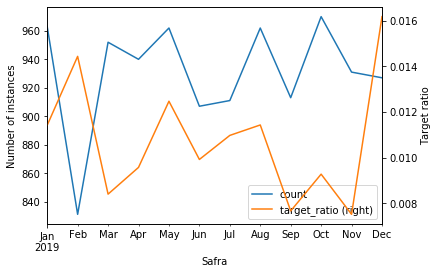

In [7]:
# Monthly analysis

df_grouped = data.groupby('Safra').agg(count = ('TARGET','count'),
                          target_ratio = ('TARGET','mean'))

ax = df_grouped[['count']].plot()
ax2 = df_grouped[['target_ratio']].plot(secondary_y=True, ax=ax)

ax.set_ylabel('Number of instances')
ax2.set_ylabel('Target ratio')

In [8]:
# Target Imbalance
print(data.TARGET.value_counts())

0    11049
1      120
Name: TARGET, dtype: int64


In [9]:
# Checking for nulls
data.isna().sum()

V1        0
V2        0
V3        0
TARGET    0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
Safra     0
dtype: int64

In [10]:
# checking datatypes
data.dtypes

V1                 int64
V2               float64
V3               float64
TARGET             int64
V4                 int64
V5                 int64
V6                 int64
V7               float64
V8                 int64
V9                 int64
V10                int64
Safra     datetime64[ns]
dtype: object

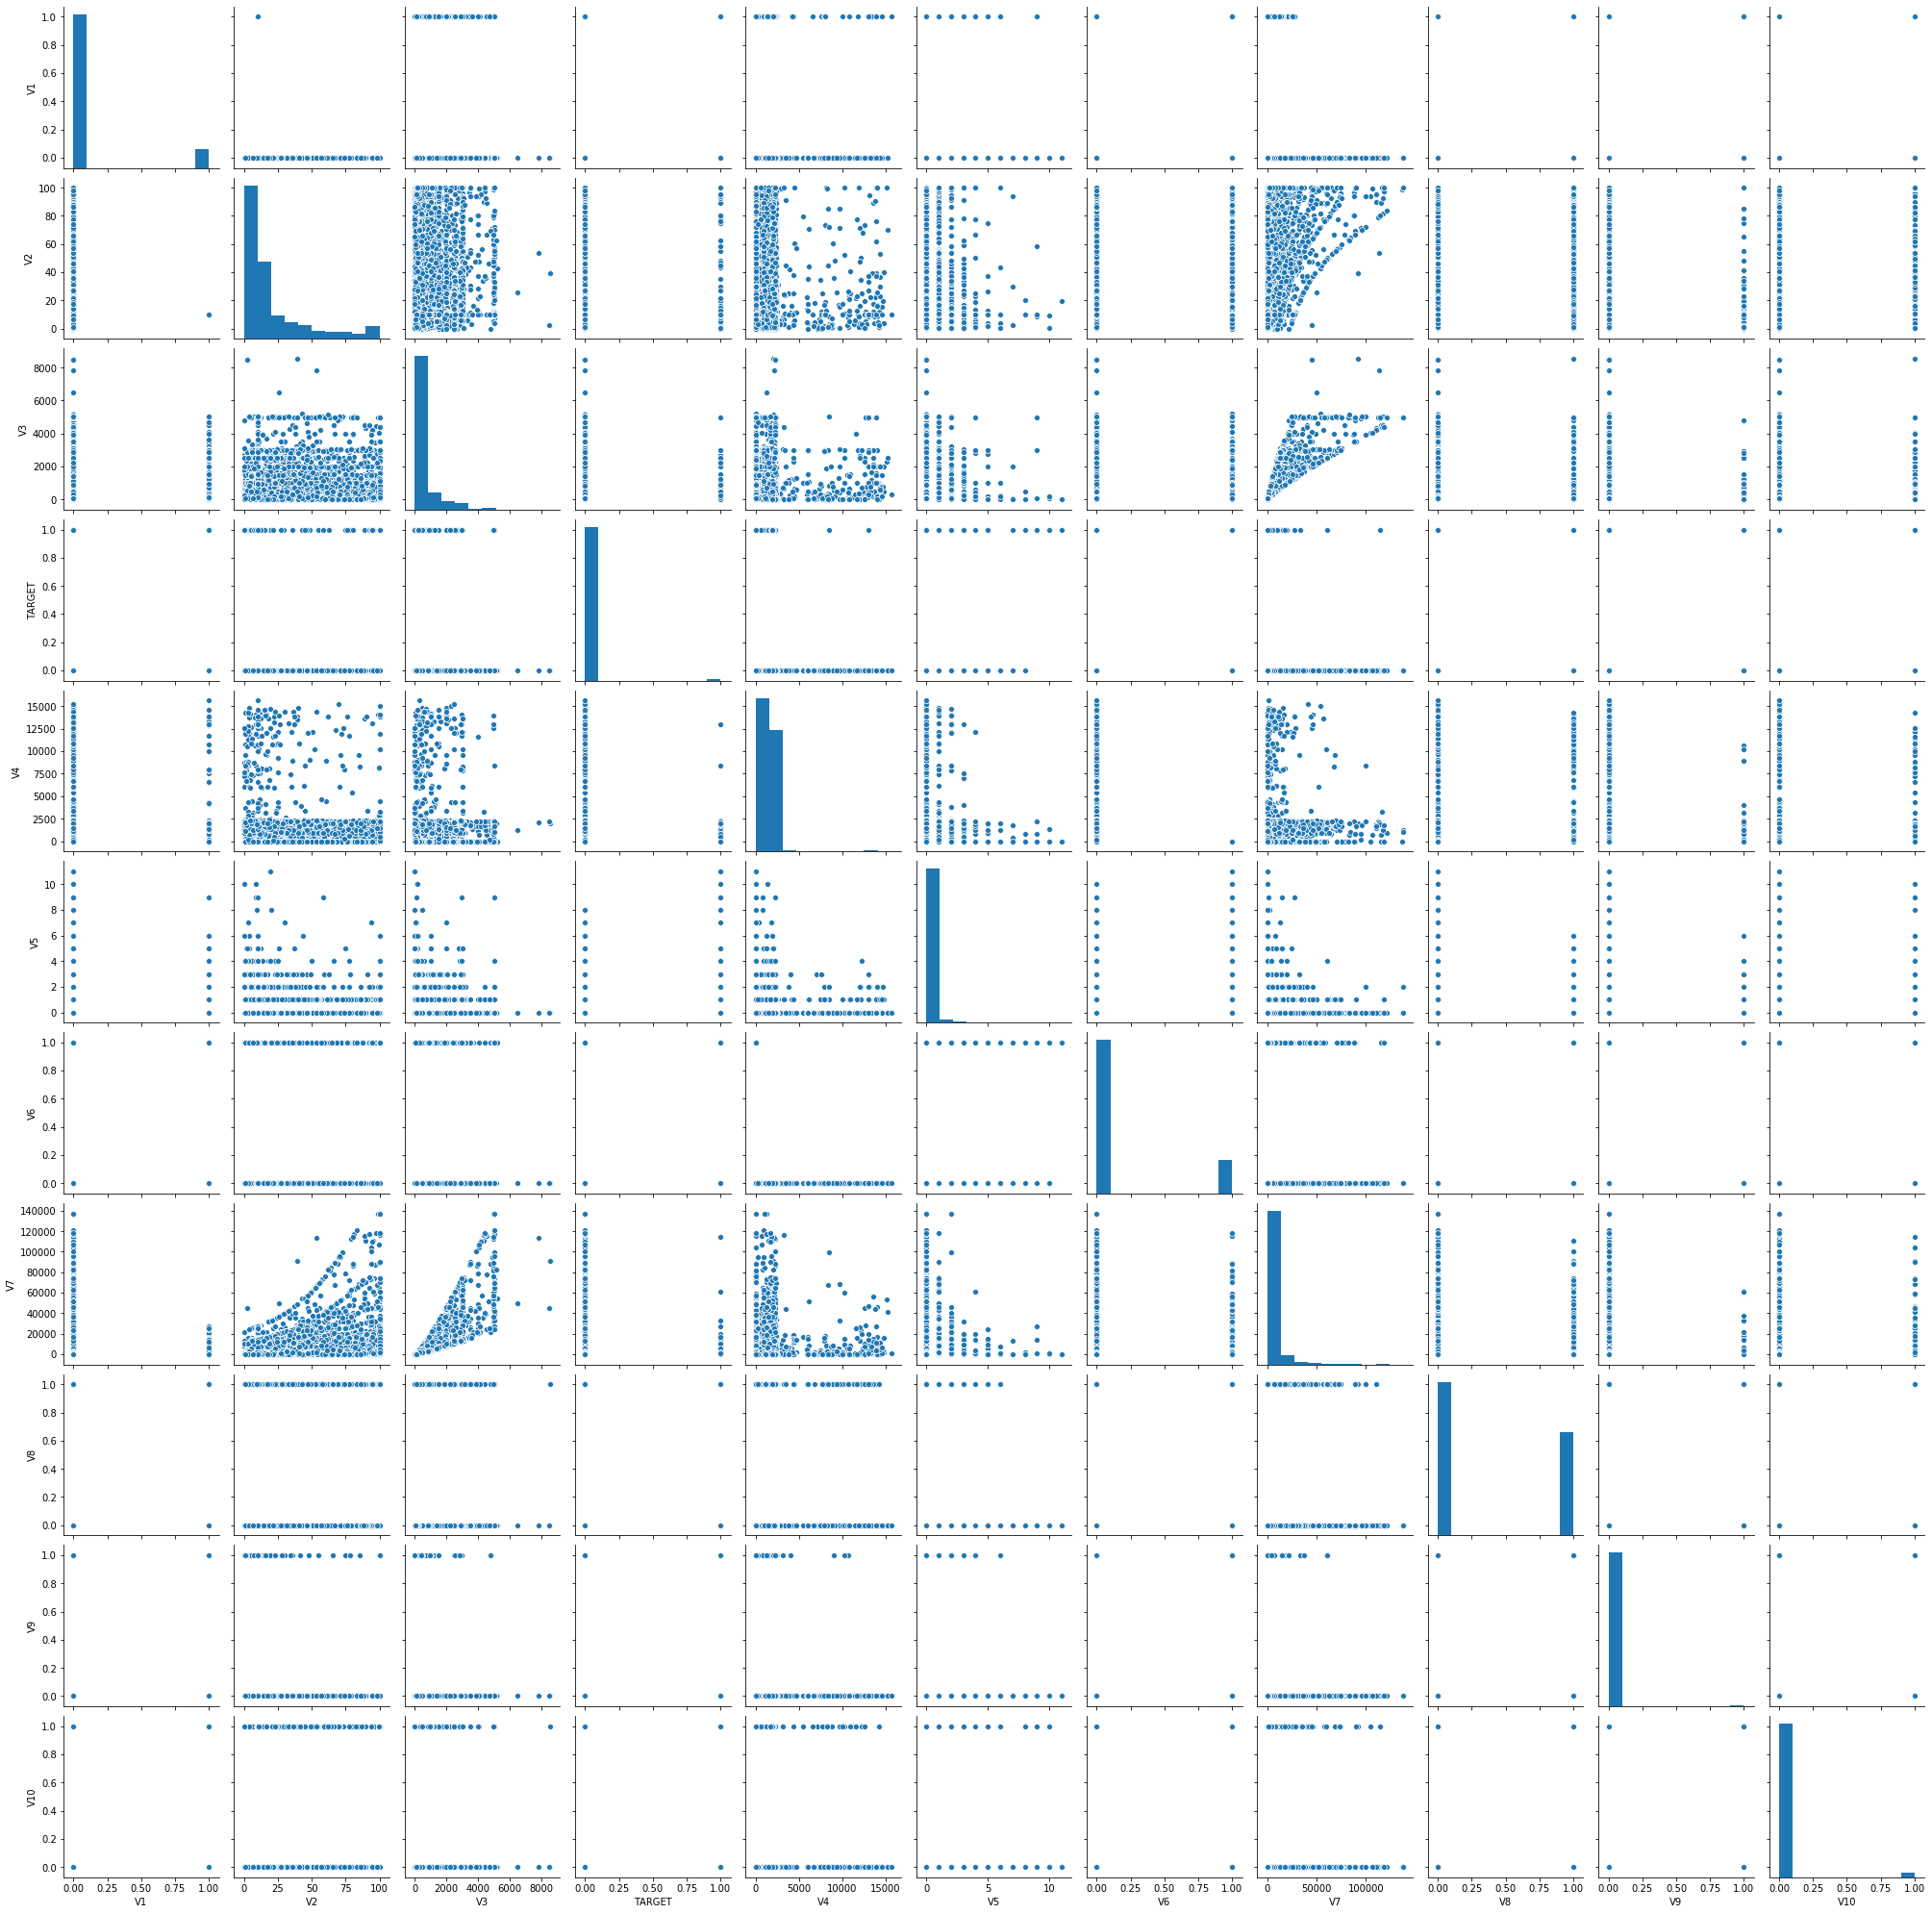

In [11]:
# pairplot

sns.pairplot(df);

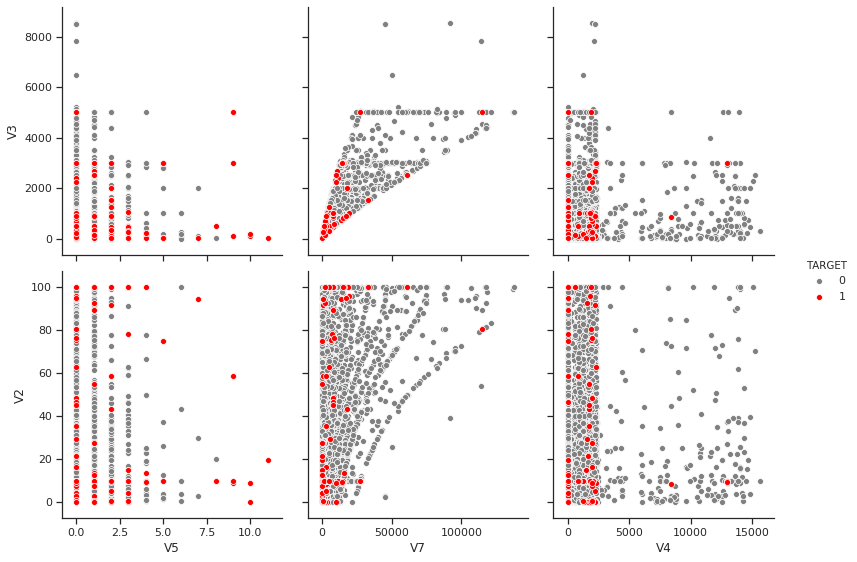

In [12]:
# Sample variables with Target discrimination

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df,
                 x_vars=["V5",'V7', 'V4'],
                 y_vars=['V3','V2'],
                 hue = 'TARGET',
                 palette = {0:'grey',1:'red'}
                )
g.fig.set_size_inches(12,8)

In [13]:
# pearson correlation  - (consider continuous varibles only)
data.corr()

,V1,V2,V3,TARGET,V4,V5,V6,V7,V8,V9,V10
V1,1.000000,-0.131918,0.113116,0.040101,0.011996,0.073170,0.052131,-0.022785,-0.141388,0.028130,0.006295
V2,-0.131918,1.000000,0.288284,0.059670,0.043436,0.012842,0.014854,0.493789,-0.117548,0.011127,0.050871
V3,0.113116,0.288284,1.000000,0.057604,0.109658,0.071141,-0.033129,0.806320,-0.258087,0.022505,0.067924
TARGET,0.040101,0.059670,0.057604,1.000000,-0.010370,0.276942,0.062794,0.042617,-0.056260,0.056546,0.052177
V4,0.011996,0.043436,0.109658,-0.010370,1.000000,0.010735,-0.373984,0.075161,-0.049161,0.021245,0.079958
V5,0.073170,0.012842,0.071141,0.276942,0.010735,1.000000,0.041572,0.025145,-0.193416,0.034109,0.073151
V6,0.052131,0.014854,-0.033129,0.062794,-0.373984,0.041572,1.000000,-0.018358,0.018710,-0.002296,-0.013152
V7,-0.022785,0.493789,0.806320,0.042617,0.075161,0.025145,-0.018358,1.000000,-0.177885,0.021699,0.080371
V8,-0.141388,-0.117548,-0.258087,-0.056260,-0.049161,-0.193416,0.018710,-0.177885,1.000000,-0.039376,-0.038875
V9,0.028130,0.011127,0.022505,0.056546,0.021245,0.034109,-0.002296,0.021699,-0.039376,1.000000,0.017565


# Modeling


In [14]:
# X and y definition (split was made considering time precedence)

X_train = df.drop(columns=['TARGET','Safra'])
y_train = df.TARGET

X_test= OOT_test.drop(columns=['TARGET','Safra'])
y_test = OOT_test.TARGET

In [15]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,0,8.1,9.99,1968,0,0,15.15,0,0,0
2,0,0.7,52.99,1228,0,0,98.84,0,0,0
4,0,4.1,17.50,0,0,1,27.70,1,0,0
6,0,100.0,105.00,0,0,1,1331.67,0,0,0
7,0,0.7,29.00,1800,0,0,47.95,1,0,0


In [16]:
# Random Forest
rf = RandomForestClassifier(random_state=seed, n_jobs=-1)

# Parameters
param_grid = {
           'criterion' : ['entropy'],
           'class_weight' : ['balanced'],
           'max_depth': [4,5,6],
           'max_features': [0.1,0.2,'auto'],
           'n_estimators': [100,200,400],
           'min_impurity_decrease':[0.001,0.005]}

# Grid Search
gridCV = GridSearchCV(
                      rf,
                      param_grid = param_grid,
                      cv = 5,
                      verbose=1,
                      scoring = 'roc_auc',
                      return_train_score = True
                     ).fit(X_train, y_train)

# Final model
clf_rf = gridCV.best_estimator_.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  4.4min finished


In [17]:
print(f"train ROC AUC : {roc_auc_score(y_train, clf_rf.predict_proba(X_train)[:,1])}")
print(f"test ROC AUC : {roc_auc_score(y_test, clf_rf.predict_proba(X_test)[:,1])}")

train ROC AUC : 0.9419561890341872
test ROC AUC : 0.8521572652727001


In [18]:
# checking best parameters
gridCV.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 0.1,
 'min_impurity_decrease': 0.005,
 'n_estimators': 400}

In [19]:
# classification report on the test dataset
print(classification_report(y_test, clf_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      2797
           1       0.06      0.68      0.11        31

    accuracy                           0.88      2828
   macro avg       0.53      0.78      0.52      2828
weighted avg       0.99      0.88      0.93      2828



In [20]:
# confusion matrix
print(confusion_matrix(y_test, clf_rf.predict_proba(X_test)[:,1] >= 0.5))

[[2473  324]
 [  10   21]]


RF: ROC AUC=0.852


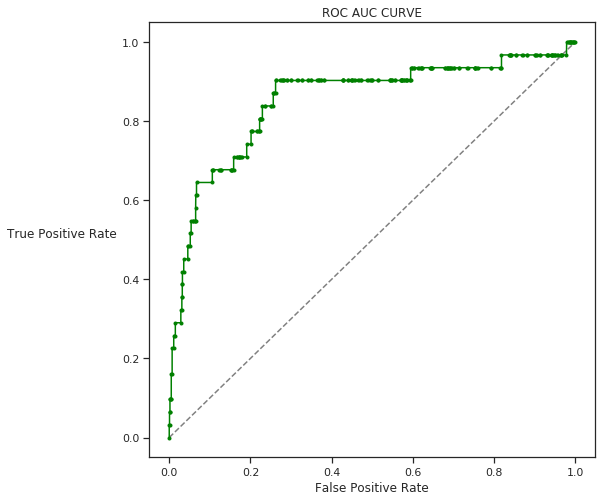

In [21]:
# roc curve and auc

ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, clf_rf.predict_proba(X_test)[:,1])
# summarize scores
print('RF: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, clf_rf.predict_proba(X_test)[:,1])
# plot the roc curve for the model
plt.figure(figsize = (8,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--',color='grey')
plt.plot(lr_fpr, lr_tpr, marker='.',color = 'green')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate',rotation=0, labelpad=60)
# title
plt.title("ROC AUC CURVE")
# show the plot
plt.show()

# Permutation Feature Importance

In [22]:
# Calculating permutation feature importance
r = permutation_importance(clf_rf, X_test, y_test,
                           n_repeats=5,
                           scoring = 'roc_auc',
                           random_state=seed,
                           n_jobs = -1)

In [23]:
# printing feature importances
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X_train.columns[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

V5      0.080 +/- 0.019
V7      0.034 +/- 0.011
V3      0.025 +/- 0.011
V4      0.017 +/- 0.007
V8      0.011 +/- 0.010
V6      0.006 +/- 0.005
V10     0.005 +/- 0.003
V2      0.005 +/- 0.002
V9      0.003 +/- 0.001
V1      -0.001 +/- 0.003
